# Create Ross Ice Shelf starting bathymetry

Use bedmachine bed data outside of the the RIS, and interpolated RIGGS seismic depths from within the ice shelf.

In [66]:
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, regions, utils, maps, profile
import pygmt
import pooch
import pandas as pd
import xarray as xr
import numpy as np
import verde as vd
import rioxarray
import zarr
import string
import geopandas as gpd
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.uncertainties as uncert

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set region and parameters

In [2]:
starting_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region = starting_region
buffer_region = vd.pad_region(starting_region, 40e3)

# set layer parameters
layer_spacing = 5e3
registration = "g"

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  [-580000.0, 420000.0, -1420000.0, -420000.0]
buffer region =  (-620000.0, 460000.0, -1460000.0, -380000.0)


# Load data

### Get Bedmachine v3 data

In [3]:
# surface
fname = "../inversion_layers/bedmachine_surface.zarr"
bedmachine_surface_full = xr.open_zarr(fname).surface
# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
bedmachine_icebase_full = xr.open_zarr(fname).icebase
# bed
fname = "../inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

bedmachine_bed_error = xr.open_zarr("../inversion_layers/bedmachine_bed_error.zarr")[
    "bed_error"
]

# resample bedmachine data at new spacing
bedmachine_surface_1k = fetch.resample_grid(
    bedmachine_surface_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)
bedmachine_icebase_1k = fetch.resample_grid(
    bedmachine_icebase_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)
bedmachine_bed_1k = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)

# resample bedmachine data at layer spacing
bedmachine_surface_layer_spacing = fetch.resample_grid(
    bedmachine_surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmachine_icebase_layer_spacing = fetch.resample_grid(
    bedmachine_icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmachine_bed_layer_spacing = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
# ensure layers never cross
bedmachine_icebase_layer_spacing = xr.where(
    bedmachine_icebase_layer_spacing > bedmachine_surface_layer_spacing,
    bedmachine_surface_layer_spacing,
    bedmachine_icebase_layer_spacing,
)

spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling


### Get Bedmap2 data

In [4]:
# surface
fname = "../inversion_layers/bedmap2_surface.zarr"
bedmap2_surface_full = xr.open_zarr(fname).surface
# icebase
fname = "../inversion_layers/bedmap2_icebase.zarr"
bedmap2_icebase_full = xr.open_zarr(fname).icebase
# bed
fname = "../inversion_layers/bedmap2_bed.zarr"
bedmap2_bed_full = xr.open_zarr(fname).bed

# resample bedmap2 data at new spacing
bedmap2_surface_1k = fetch.resample_grid(
    bedmap2_surface_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)
bedmap2_icebase_1k = fetch.resample_grid(
    bedmap2_icebase_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)
bedmap2_bed_1k = fetch.resample_grid(
    bedmap2_bed_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)

# resample bedmachine data at layer spacing
bedmap2_surface_layer_spacing = fetch.resample_grid(
    bedmap2_surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmap2_icebase_layer_spacing = fetch.resample_grid(
    bedmap2_icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmap2_bed_layer_spacing = fetch.resample_grid(
    bedmap2_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
# ensure layers never cross
bedmap2_icebase_layer_spacing = xr.where(
    bedmap2_icebase_layer_spacing > bedmap2_surface_layer_spacing,
    bedmap2_surface_layer_spacing,
    bedmap2_icebase_layer_spacing,
)

spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling


In [5]:
# fig = maps.plot_grd(
#     bedmachine_bed_full,
#     cmap="rain",
#     reverse_cpt=True,
#     grd2cpt=True,
#     cbar_label="Bedmachine Bed (m)",
#     hist=True,
#     cbar_yoffset=4,
# )
# fig = maps.plot_grd(
#     bedmachine_bed_error,
#     cmap="matter",
#     cpt_lims=[0,100],
#     grd2cpt=True,
#     cbar_label="Bedmachine Bed Error (m)",
#     hist=True,
#     cbar_yoffset=4,
#     fig=fig,
#     origin_shift="xshift",
# )
# fig.show()

# Method 1: fit spline to just data near NaN's, merge to bedmachine

## get RIS seismic depths

In [6]:
# fname = inv_utils.fetch_private_github_file(
#     "bedmap1.csv.gz",
#     fpath="RIS_grav_bath_data/main/processing",
#     output_dir="../data/",
# )

In [7]:
fname = "../data/bedmap1.csv.gz"

RIS_points = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

RIS_points = RIS_points.rename(
    columns={"x": "easting", "y": "northing", "z_ellipsoidal": "upward"}
)

RIS_points["inside"] = True

print(f"bathymetry control points:{len(RIS_points)}")
RIS_points.describe()

bathymetry control points:223


easting      northing         lat         lon  station_ID  \
count     223.000000  2.230000e+02  223.000000  223.000000  223.000000   
mean   -68866.120591 -1.019148e+06  -80.352235   -9.656647   13.699552   
std    250718.371845  1.798082e+05    1.687297  168.173939    8.608311   
min   -552131.657413 -1.338933e+06  -84.600000 -179.819200    1.000000   
25%   -272862.377514 -1.156648e+06  -81.603470 -165.579050    1.000000   
50%    -52178.399561 -1.037217e+06  -79.976110 -154.674400   19.000000   
75%    159939.301858 -8.784096e+05  -79.044165  170.377200   19.000000   
max    370320.590763 -5.637318e+05  -77.656670  179.950300   25.000000   

            upward    z_geoidal  z_error  measurement_type  
count   223.000000   223.000000      0.0               0.0  
mean   -727.022271  -676.533632      NaN               NaN  
std     161.481616   161.808745      NaN               NaN  
min   -1448.357368 -1397.000000      NaN               NaN  
25%    -799.850694  -750.000000      NaN               NaN  
50%    -725.388194  -676.000000      NaN               NaN  
75%    -612.915614  -564.000000      NaN               NaN  
max    -407.527543  -354.000000      NaN               NaN

In [8]:
RIS_points = profile.sample_grids(
    RIS_points,
    bedmap2_bed_full,
    name="bedmap2",
    coord_names=["easting", "northing"],
)

RIS_points["dif"] = RIS_points.bedmap2 - RIS_points.upward

print("Difference with bedmap2: ", utils.RMSE(RIS_points.dif))

RIS_points.sort_values(by="dif").describe()

Difference with bedmap2:  137.8432744171251


easting      northing         lat         lon  station_ID  \
count     223.000000  2.230000e+02  223.000000  223.000000  223.000000   
mean   -68866.120591 -1.019148e+06  -80.352235   -9.656647   13.699552   
std    250718.371845  1.798082e+05    1.687297  168.173939    8.608311   
min   -552131.657413 -1.338933e+06  -84.600000 -179.819200    1.000000   
25%   -272862.377514 -1.156648e+06  -81.603470 -165.579050    1.000000   
50%    -52178.399561 -1.037217e+06  -79.976110 -154.674400   19.000000   
75%    159939.301858 -8.784096e+05  -79.044165  170.377200   19.000000   
max    370320.590763 -5.637318e+05  -77.656670  179.950300   25.000000   

            upward    z_geoidal  z_error  measurement_type      bedmap2  \
count   223.000000   223.000000      0.0               0.0   223.000000   
mean   -727.022271  -676.533632      NaN               NaN  -680.545572   
std     161.481616   161.808745      NaN               NaN   178.955753   
min   -1448.357368 -1397.000000      NaN               NaN -1333.559711   
25%    -799.850694  -750.000000      NaN               NaN  -778.338647   
50%    -725.388194  -676.000000      NaN               NaN  -684.369629   
75%    -612.915614  -564.000000      NaN               NaN  -589.933758   
max    -407.527543  -354.000000      NaN               NaN   -91.307901   

              dif  
count  223.000000  
mean    46.476700  
std    130.063614  
min   -148.869581  
25%     -5.925607  
50%      3.853209  
75%     33.759104  
max    786.525794

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


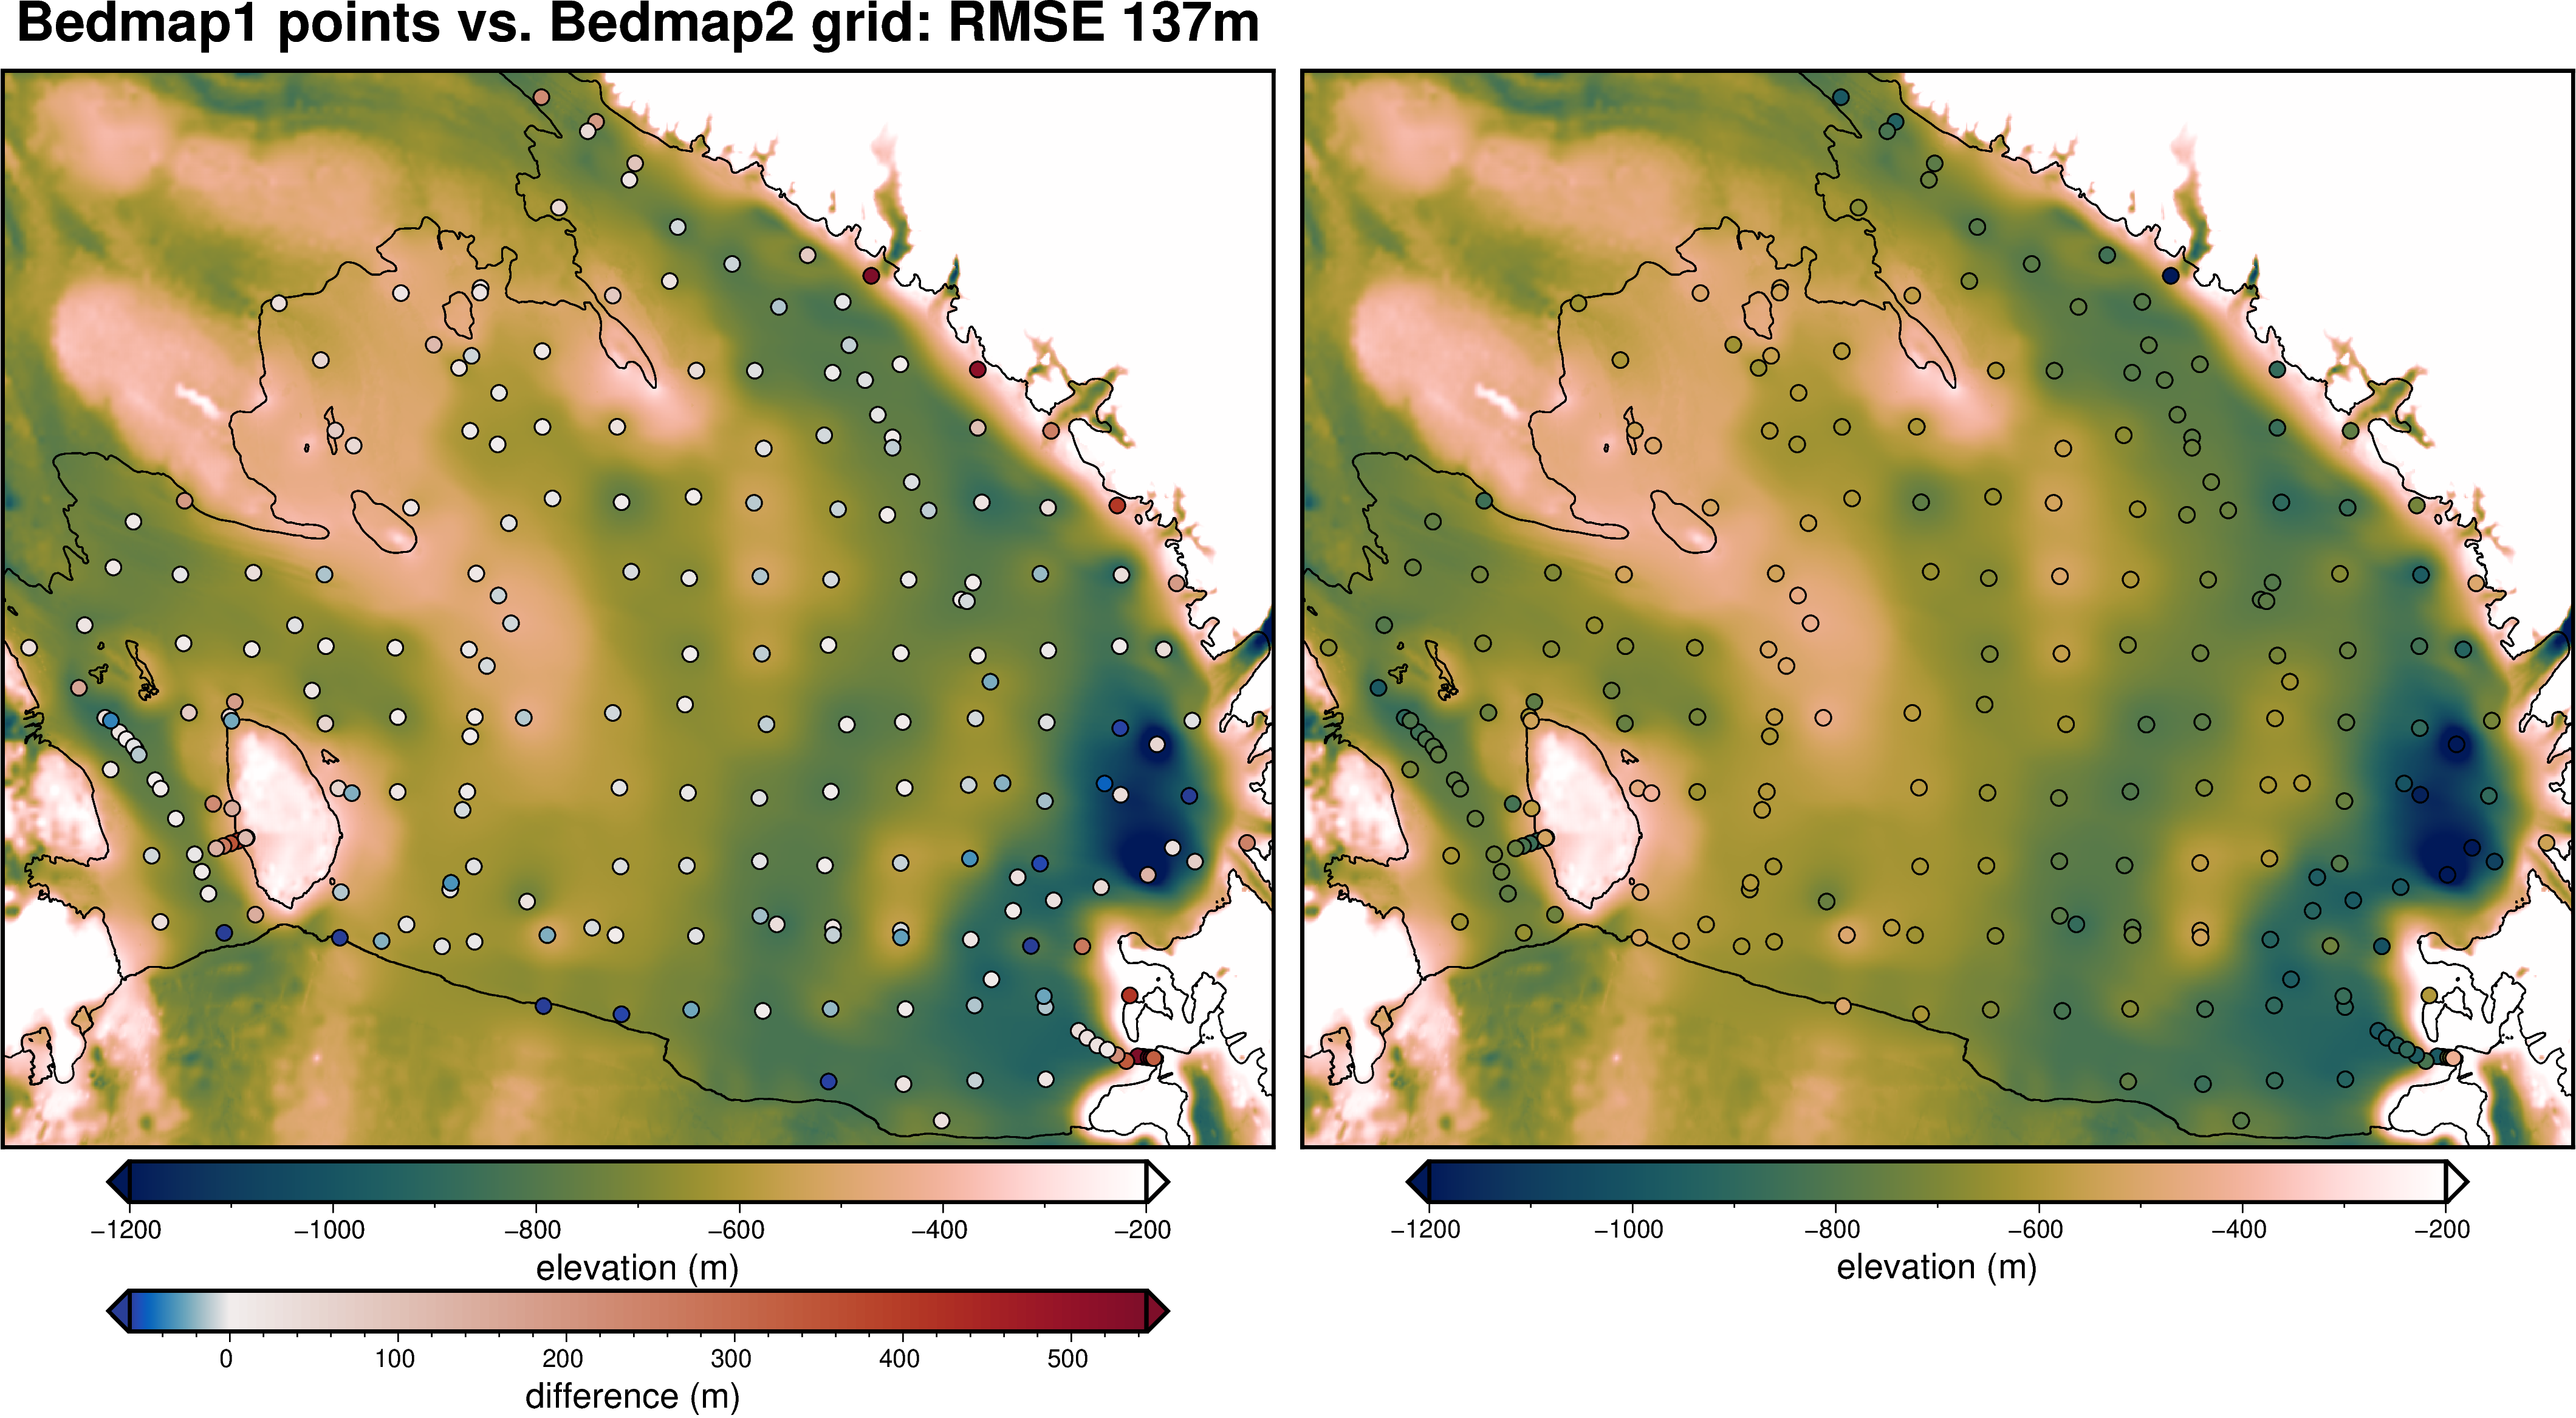

In [9]:
rmse = int(utils.RMSE(RIS_points.dif))
fig = maps.plot_grd(
    bedmap2_bed_full,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(
        vd.get_region((RIS_points.easting, RIS_points.northing)), 20e3
    ),
    coast=True,
    title=f"Bedmap1 points vs. Bedmap2 grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(RIS_points.dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=RIS_points.easting,
    y=RIS_points.northing,
    fill=RIS_points.dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    bedmap2_bed_full,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(
        vd.get_region((RIS_points.easting, RIS_points.northing)), 20e3
    ),
    coast=True,
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=RIS_points.easting,
    y=RIS_points.northing,
    fill=RIS_points.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [10]:
RIS_points.drop(columns=["dif", "bedmap2"], inplace=True)

In [11]:
# get RIS area
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS_area = RIS_seperate.dissolve().area.values[0] / 10**6

print(f"ice shelf area: {round(RIS_area)} km\u00b2")
print(
    "Ross Ice Shelf constraint density: 1 constraint per "
    f"{int(RIS_area / len(RIS_points))} km\u00b2"
)

ice shelf area: 480428 km²
Ross Ice Shelf constraint density: 1 constraint per 2154 km²


## give inside points an uncertainty of 5% depth from surface

In [12]:
# sample ice surface elevation into dataframe
# from bedmachine,
RIS_points = profile.sample_grids(
    RIS_points,
    bedmachine_surface_full,
    "surface_z_ellipsoidal",
    coord_names=["easting", "northing"],
)

# calculate error as 5% of depth from surface
depth = RIS_points.surface_z_ellipsoidal - RIS_points.upward
uncertaint = 0.05 * depth

RIS_points.loc[RIS_points.index, "z_error"] = uncertaint


print(f"mean uncertainty inside RIS: {np.nanmean(RIS_points.z_error)} m")

RIS_points.describe()

mean uncertainty inside RIS: 35.98642118025852 m


easting      northing         lat         lon  station_ID  \
count     223.000000  2.230000e+02  223.000000  223.000000  223.000000   
mean   -68866.120591 -1.019148e+06  -80.352235   -9.656647   13.699552   
std    250718.371845  1.798082e+05    1.687297  168.173939    8.608311   
min   -552131.657413 -1.338933e+06  -84.600000 -179.819200    1.000000   
25%   -272862.377514 -1.156648e+06  -81.603470 -165.579050    1.000000   
50%    -52178.399561 -1.037217e+06  -79.976110 -154.674400   19.000000   
75%    159939.301858 -8.784096e+05  -79.044165  170.377200   19.000000   
max    370320.590763 -5.637318e+05  -77.656670  179.950300   25.000000   

            upward    z_geoidal     z_error  measurement_type  \
count   223.000000   223.000000  223.000000               0.0   
mean   -727.022271  -676.533632   35.986421               NaN   
std     161.481616   161.808745    8.188563               NaN   
min   -1448.357368 -1397.000000   18.451929               NaN   
25%    -799.850694  -750.000000   30.193173               NaN   
50%    -725.388194  -676.000000   35.832436               NaN   
75%    -612.915614  -564.000000   39.957439               NaN   
max    -407.527543  -354.000000   72.332364               NaN   

       surface_z_ellipsoidal  
count             223.000000  
mean               -7.293848  
std                16.829854  
min               -55.000000  
25%               -16.065833  
50%               -10.404933  
75%                 3.025251  
max                51.129775

## make mask of buffer ice shelf border

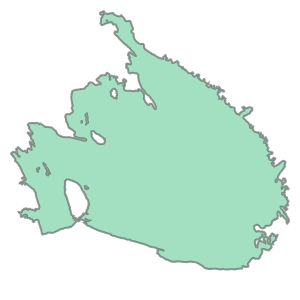

In [13]:
# fetch MEaSURES iceshelf shapefiles
measures_shelves = fetch.measures_boundaries(version="IceShelf")
# read into a geodataframe
ice_shelves = gpd.read_file(measures_shelves)
# extract Ross Ice Shelf east and west polygons
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
# merge into 1 polygon
RIS = RIS_seperate.dissolve()
RIS.geometry[0]

## Make constraint points dataframe

Ross Ice Shelf sparse constraints inside ice shelf, and gridded Bedmachine bed outside of ice shelf at 5km cell size.

In [14]:
# regrid bed data at spacing
bed = fetch.resample_grid(
    bedmachine_bed_full,
    # bedmap2_bed_full,
    spacing=layer_spacing,
    registration=registration,
    region=buffer_region,
)

# bed_error = fetch.resample_grid(
#     bedmachine_bed_error,
#     spacing=layer_spacing,
#     registration=registration,
#     region=region,
# )

# get grid points outside of RIS
_, outside_points, _ = inv_utils.get_buffer_points(
    buffer_width=layer_spacing,
    grid=bed,
    mask=RIS,
    # plot = True,
)

# label outside points and set error
outside_points["inside"] = False
outside_points["z_error"] = 10

# merge outside and inside points
outside_and_inside_points = pd.concat((outside_points, RIS_points))

# set weighting values
outside_and_inside_points["weights"] = 1 / (outside_and_inside_points.z_error**2)

outside_and_inside_points.drop(
    columns=outside_and_inside_points.columns.difference(
        ["northing", "easting", "upward", "z_error", "inside", "weights"]
    ),
    inplace=True,
)

constraints = outside_and_inside_points.copy()

# save constraints to csv
constraints.to_csv(
    f"../data/bed_constraints.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

constraints

spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


northing        easting       upward  inside    z_error   weights
0   -1.460000e+06 -620000.000000 -3610.029053   False  10.000000  0.010000
1   -1.460000e+06 -615000.000000 -3606.817627   False  10.000000  0.010000
2   -1.460000e+06 -610000.000000 -3592.935547   False  10.000000  0.010000
3   -1.460000e+06 -605000.000000 -3583.679688   False  10.000000  0.010000
4   -1.460000e+06 -600000.000000 -3592.669189   False  10.000000  0.010000
..            ...            ...          ...     ...        ...       ...
218 -1.206553e+06  206601.786491  -731.829528    True  35.822378  0.000779
219 -1.200263e+06 -316755.706913  -521.706527    True  24.728047  0.001635
220 -1.092887e+06  326582.733297  -885.094801    True  44.006194  0.000516
221 -1.196613e+06 -404256.274102  -651.903650    True  31.641187  0.000999
222 -1.252059e+06 -162545.223180  -500.551980    True  22.277599  0.002015

[28087 rows x 6 columns]

## interpolate inside and buffer zone points
necessary to seperate from outside points since they are already gridded and interpolating with than many points is unfeasable

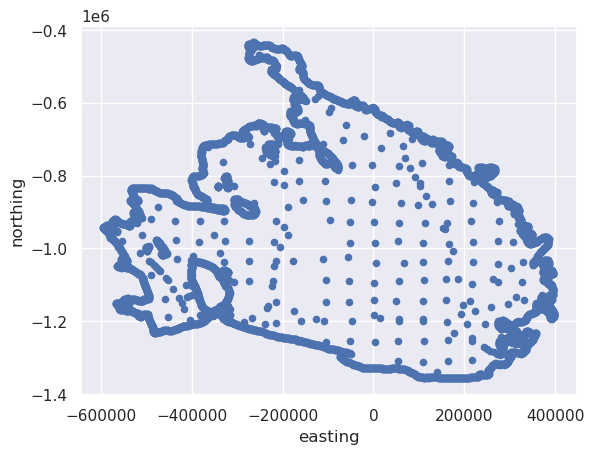

In [15]:
new_spacing = 1e3

# get buffered border and grid with inside RIS masked
buffer_points, _, bed_outside = inv_utils.get_buffer_points(
    buffer_width=new_spacing,
    grid=bedmachine_bed_1k,
    mask=RIS,
    # plot = True,
)

# label outside points and set error
buffer_points["inside"] = False
buffer_points["z_error"] = 10

# merge buffer and inside points
buffer_and_inside_points = pd.concat((buffer_points, RIS_points))

# plot points
buffer_and_inside_points.plot.scatter(x="easting", y="northing")

# set weighting values
buffer_and_inside_points["weights"] = 1 / (buffer_and_inside_points.z_error**2)

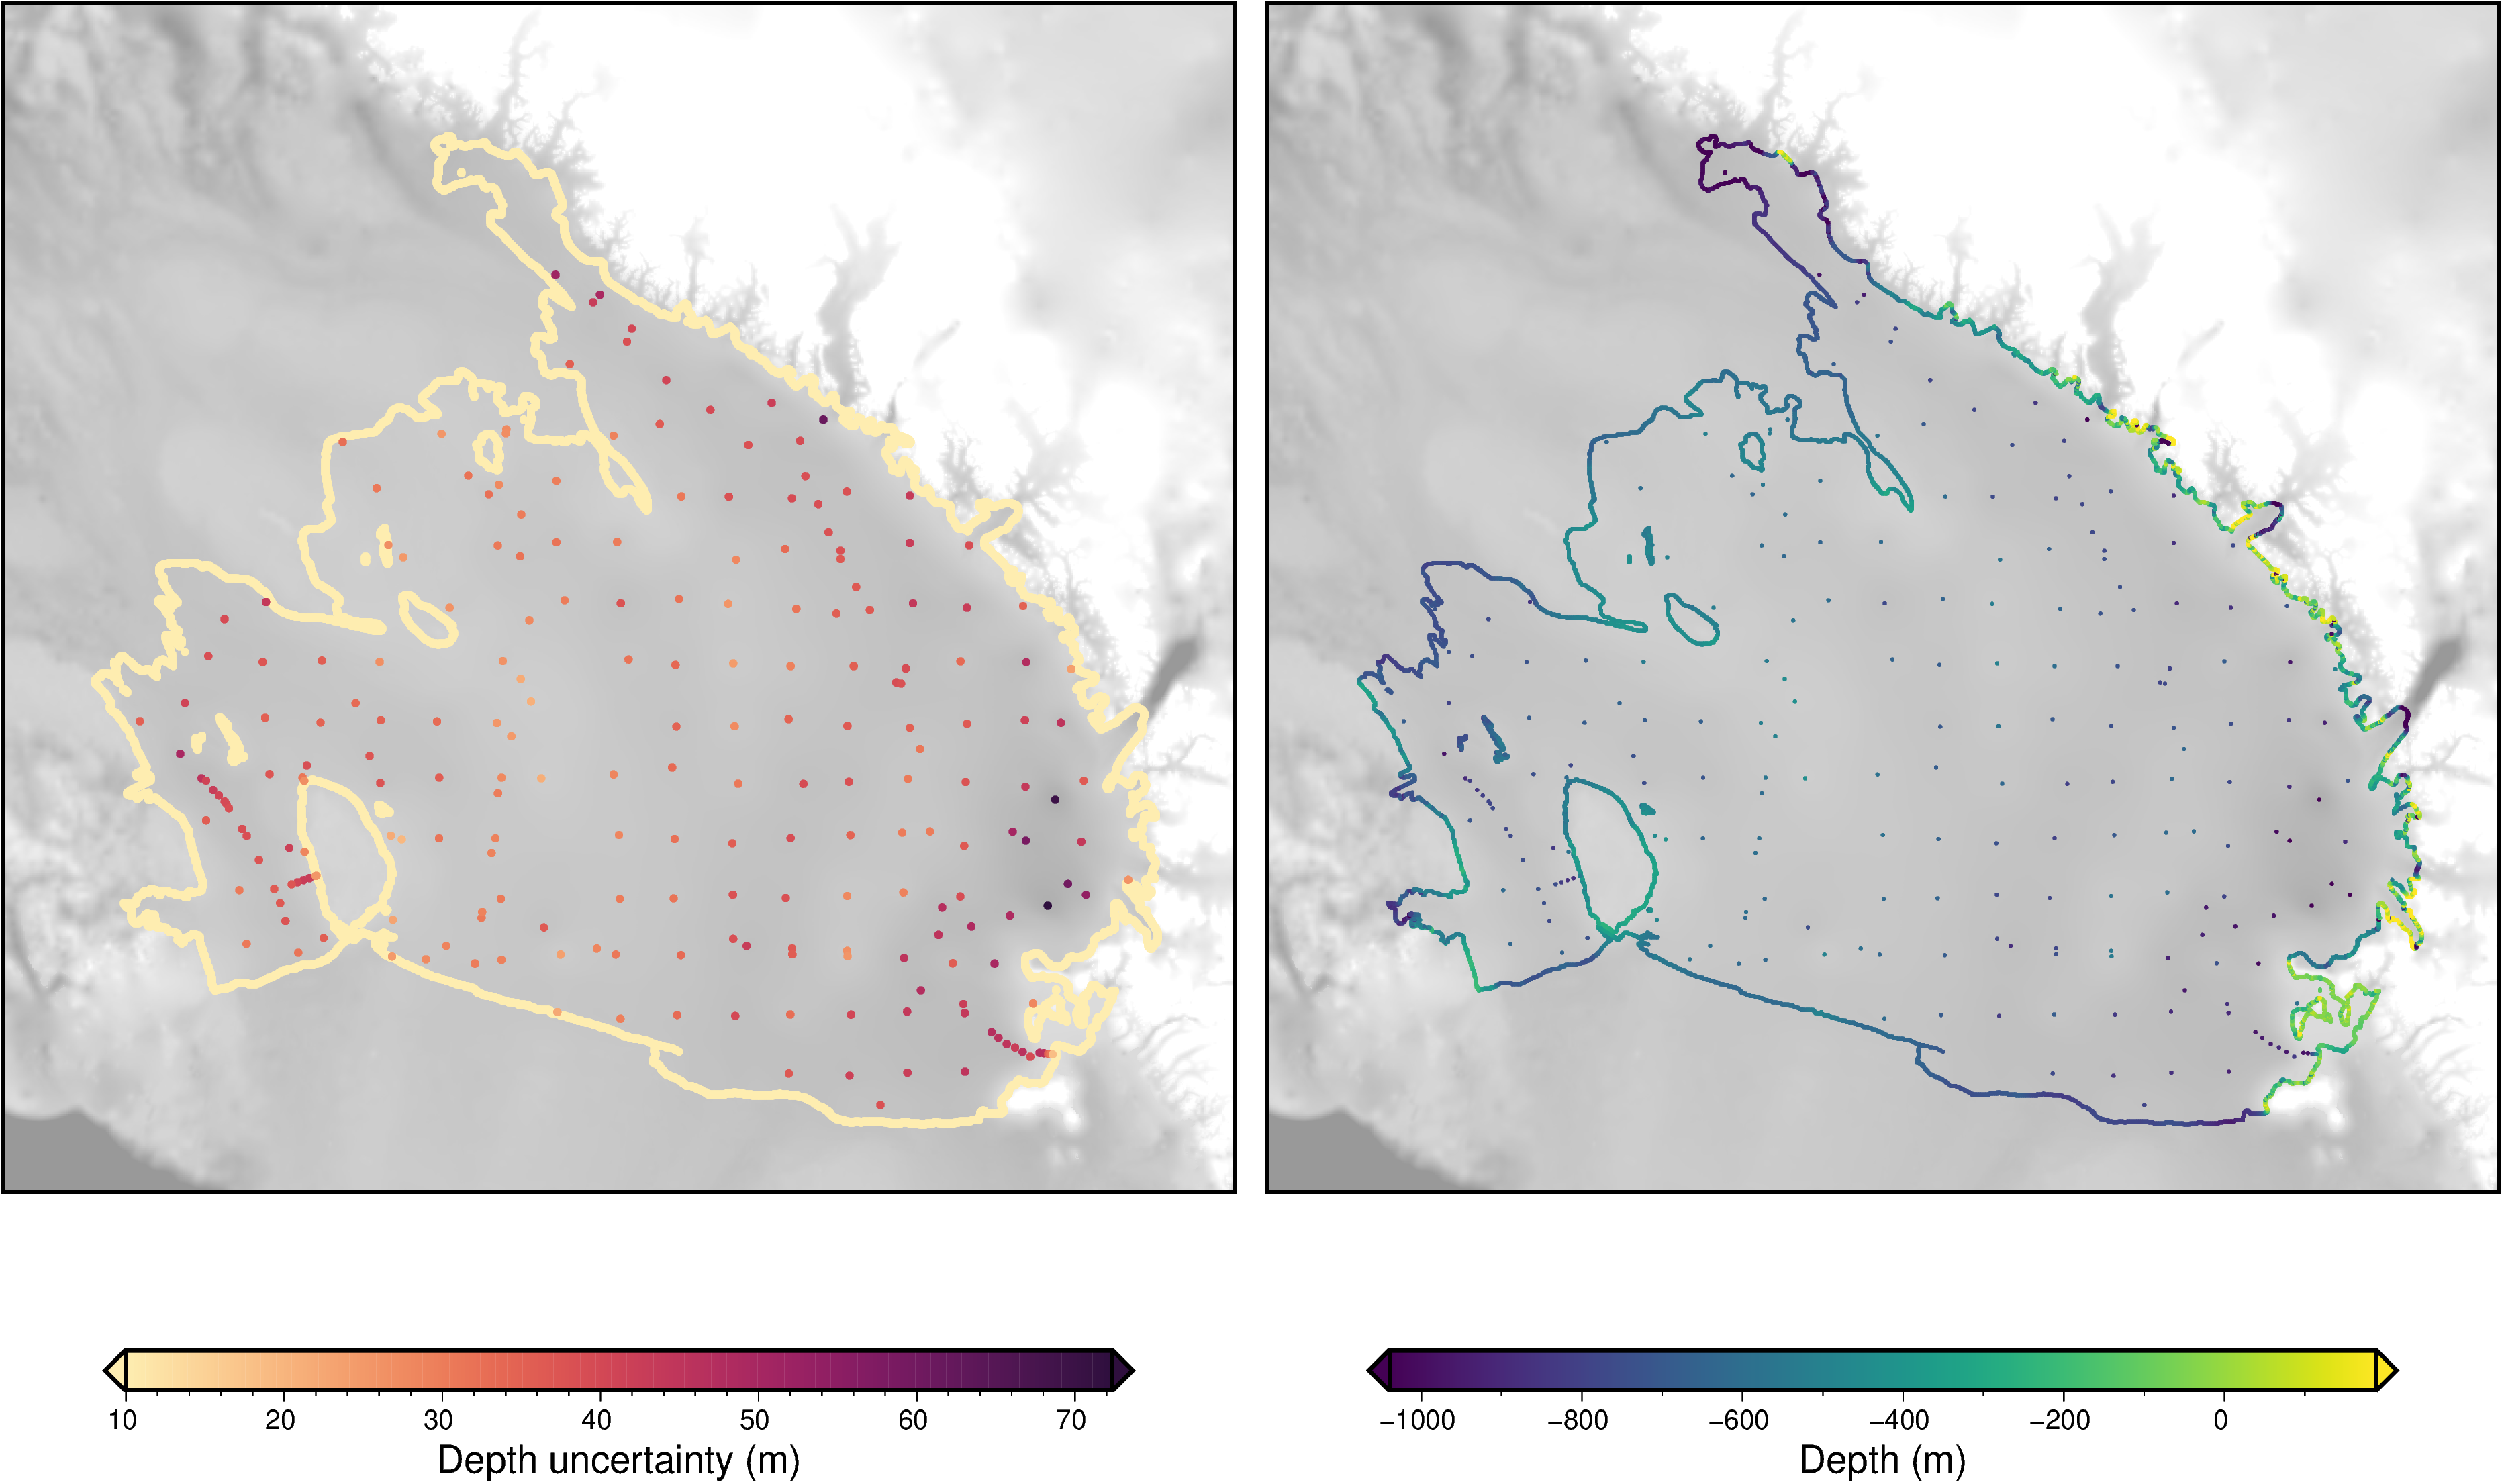

In [23]:
df = buffer_and_inside_points

fig = maps.plot_grd(
    # bedmachine_bed,
    bedmap2_bed_full,
    region=regions.ross_ice_shelf,
    cmap="gray",
    transparency=60,
    cpt_lims=[-2000, 1000],
    colorbar=False,
)
pygmt.makecpt(
    cmap="matter",
    series=utils.get_min_max(df.z_error, robust=False),
    background="o",
)
fig.plot(
    x=df.easting,
    y=df.northing,
    style="c.1c",
    fill=df.z_error,
    cmap=True,
)

maps.add_colorbar(fig=fig, cbar_label="Depth uncertainty (m)", cbar_yoffset=2)

fig = maps.plot_grd(
    # bedmachine_bed,
    bedmap2_bed_full,
    region=regions.ross_ice_shelf,
    cmap="gray",
    transparency=60,
    cpt_lims=[-2000, 1000],
    colorbar=False,
    fig=fig,
    origin_shift="xshift",
)

pygmt.makecpt(
    cmap="viridis",
    series=utils.get_min_max(df.upward, robust=True),
    background="o",
)
fig.plot(
    x=df.easting,
    y=df.northing,
    style="c.05c",
    fill=df.upward,
    cmap=True,
)

maps.add_colorbar(fig=fig, cbar_label="Depth (m)", cbar_yoffset=2)

fig.show()

### with verde.Spline

spacing larger than original, filtering and resampling


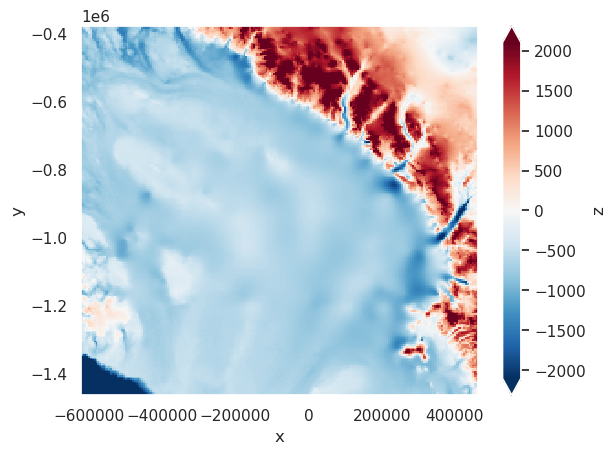

In [17]:
bed_from_constraints_verde_spline = inv_utils.create_starting_bed(
    buffer_and_inside_points=buffer_and_inside_points,
    masked_bed=bed_outside,
    region=buffer_region,
    spacing=new_spacing,
    icebase=bedmachine_icebase_1k,
    surface=bedmachine_surface_1k,
    # method = "surface",
    # tension = .5,
    method="spline",
    damping=10e-15,  # -50 gives same as -100
    weights_col_name="weights",
)

# resample to specified layer_spacing (5k)
bed_from_constraints_verde_spline = fetch.resample_grid(
    bed_from_constraints_verde_spline,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

bed_from_constraints_verde_spline_clip = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    xr_grid=bed_from_constraints_verde_spline,
    masked=True,
    invert=False,
)
bed_from_constraints_verde_spline.plot(robust=True)

### with pygmt.Surface

spacing larger than original, filtering and resampling


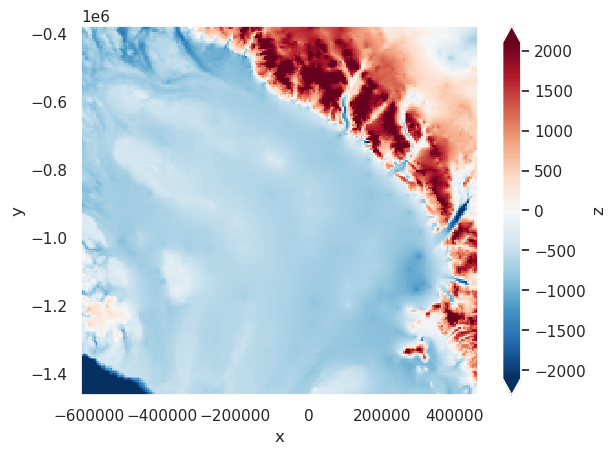

In [26]:
bed_from_constraints_gmt_surface = inv_utils.create_starting_bed(
    buffer_and_inside_points=buffer_and_inside_points,
    masked_bed=bed_outside,
    region=buffer_region,
    spacing=new_spacing,
    icebase=bedmachine_icebase_1k,
    surface=bedmachine_surface_1k,
    method="surface",
    tension=0.5,
    # method = "spline",
    # damping = 10e-50, #-50 gives same as -100
    # weights_col_name = "weights",
)

# resample to specified layer spacing (5k)
bed_from_constraints_gmt_surface = fetch.resample_grid(
    bed_from_constraints_gmt_surface,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

bed_from_constraints_gmt_surface_clip = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    xr_grid=bed_from_constraints_gmt_surface,
    masked=True,
    invert=False,
)
bed_from_constraints_gmt_surface.plot(robust=True)

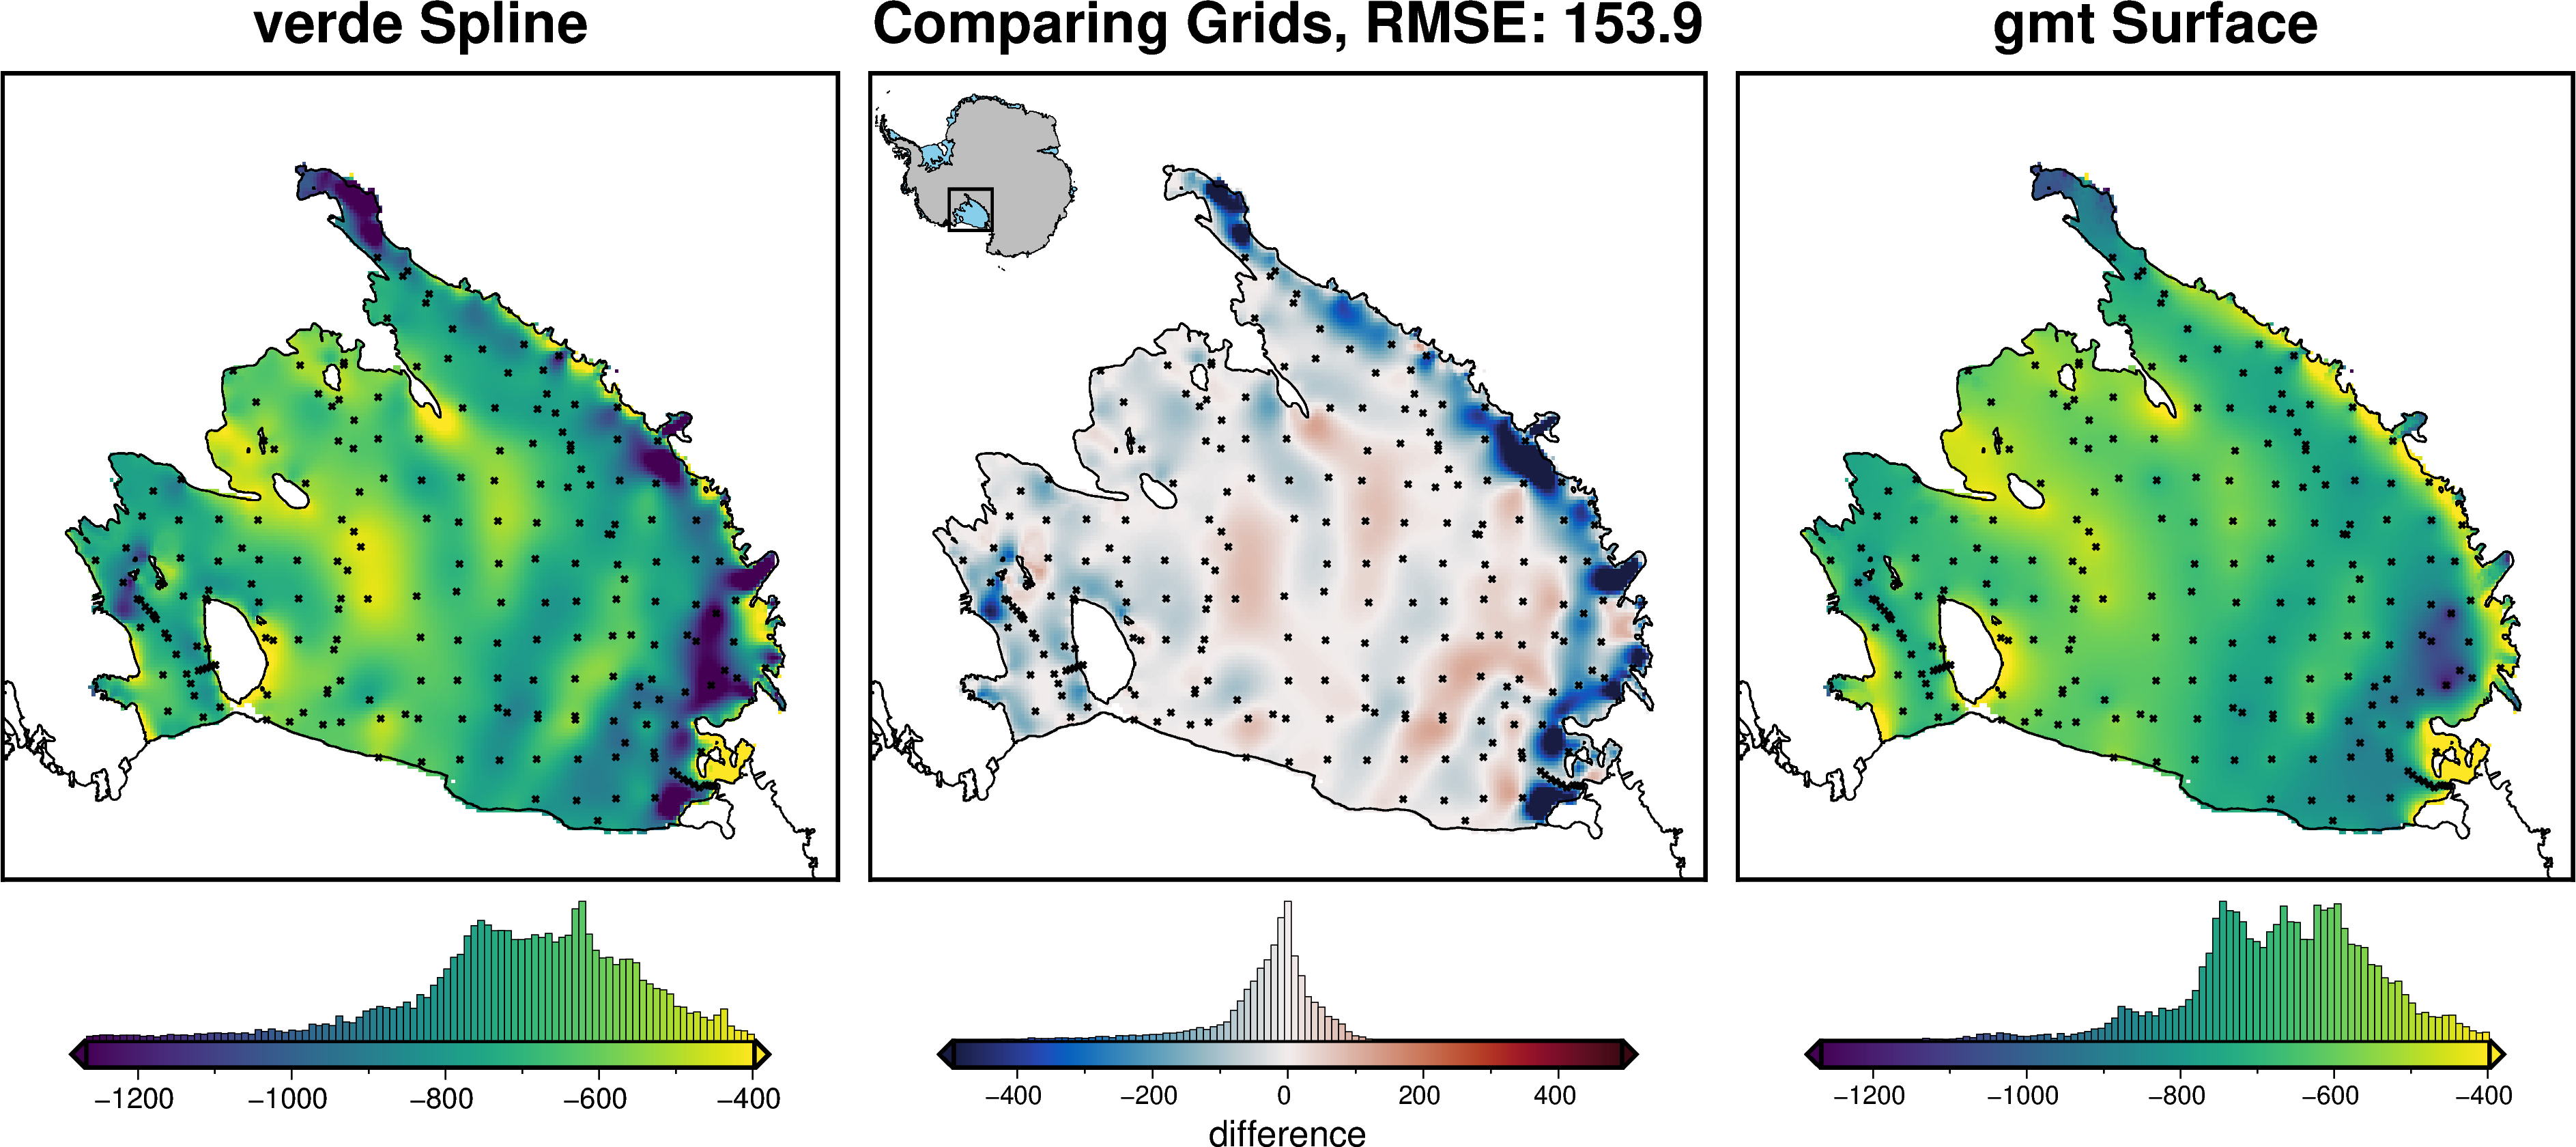

In [27]:
_ = utils.grd_compare(
    bed_from_constraints_verde_spline_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    grid1_name="verde Spline",
    grid2_name="gmt Surface",
    hist=True,
    # shp_mask="../plotting/RIS_outline.shp",
)

In [28]:
# ensure 5k versions don't cross with icebase or surface
bed_from_constraints_verde_spline = inv_utils.ensure_no_crossing(
    bed_from_constraints_verde_spline,
    icebase=bedmachine_icebase_layer_spacing,
    surface=bedmachine_surface_layer_spacing,
)
bed_from_constraints_gmt_surface = inv_utils.ensure_no_crossing(
    bed_from_constraints_gmt_surface,
    icebase=bedmachine_icebase_layer_spacing,
    surface=bedmachine_surface_layer_spacing,
)

In [32]:
# save to zarr
bed_from_constraints_verde_spline = bed_from_constraints_verde_spline.to_dataset(
    name="bed"
)
bed_from_constraints_verde_spline.to_zarr(
    "../inversion_layers/bed_from_constraints_verde_spline.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)
bed_from_constraints_gmt_surface = bed_from_constraints_gmt_surface.to_dataset(
    name="bed"
)
bed_from_constraints_gmt_surface.to_zarr(
    "../inversion_layers/bed_from_constraints_gmt_surface.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)

In [18]:
bed_from_constraints_verde_spline2 = xr.open_zarr(
    "../inversion_layers/bed_from_constraints_verde_spline.zarr",
).bed
bed_from_constraints_gmt_surface = xr.open_zarr(
    "../inversion_layers/bed_from_constraints_gmt_surface.zarr",
).bed

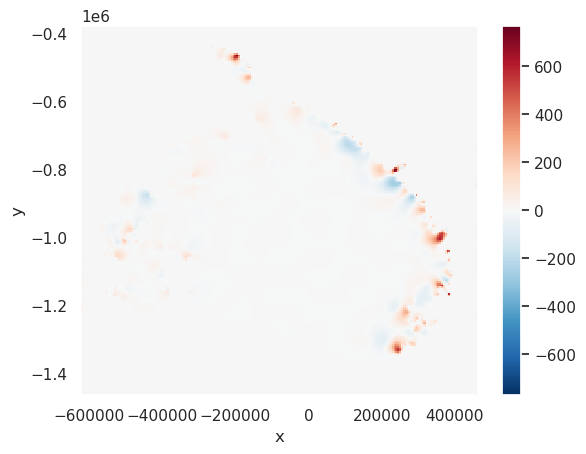

In [19]:
(bed_from_constraints_verde_spline - bed_from_constraints_verde_spline2).plot()

In [34]:
utils.get_grid_info(bed_from_constraints_verde_spline)

(5000.0,
 [-620000.0, 460000.0, -1460000.0, -380000.0],
 -3684.76123047,
 4054.42260742,
 'g')

In [35]:
utils.get_grid_info(bed_from_constraints_gmt_surface)

(5000.0,
 [-620000.0, 460000.0, -1460000.0, -380000.0],
 -3684.76123047,
 4054.42260742,
 'g')

# Ensemble of starting beds

In [21]:
# get RIS mask
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS = RIS_seperate.dissolve()

# get points within ice shelf border and buffered border
buffer_points, _, bed_outside = inv_utils.get_buffer_points(
    buffer_width=1e3,
    grid=bedmachine_bed_1k,
    mask=RIS,
    # plot = True,
)

In [ ]:
verde_spline_grids = []
dampings = [10**-20, 10**-15, 10**-10]
for i, d in enumerate(dampings):
    g = inv_utils.recreate_bed(
        inside_points=constraints[constraints.inside],
        buffer_points=buffer_points,
        outside_grid=bed_outside,
        region=buffer_region,
        fullres_spacing=1e3,
        layer_spacing=layer_spacing,
        method="spline",
        damping=d,
        use_weights=False,
        icebase=bedmachine_icebase_layer_spacing,
        surface=bedmachine_surface_layer_spacing,
        icebase_fullres=bedmachine_icebase_1k,
        surface_fullres=bedmachine_surface_1k,
    )
    g = g.rename(f"spline_{string(i)}")

    verde_spline_grids.append(g)

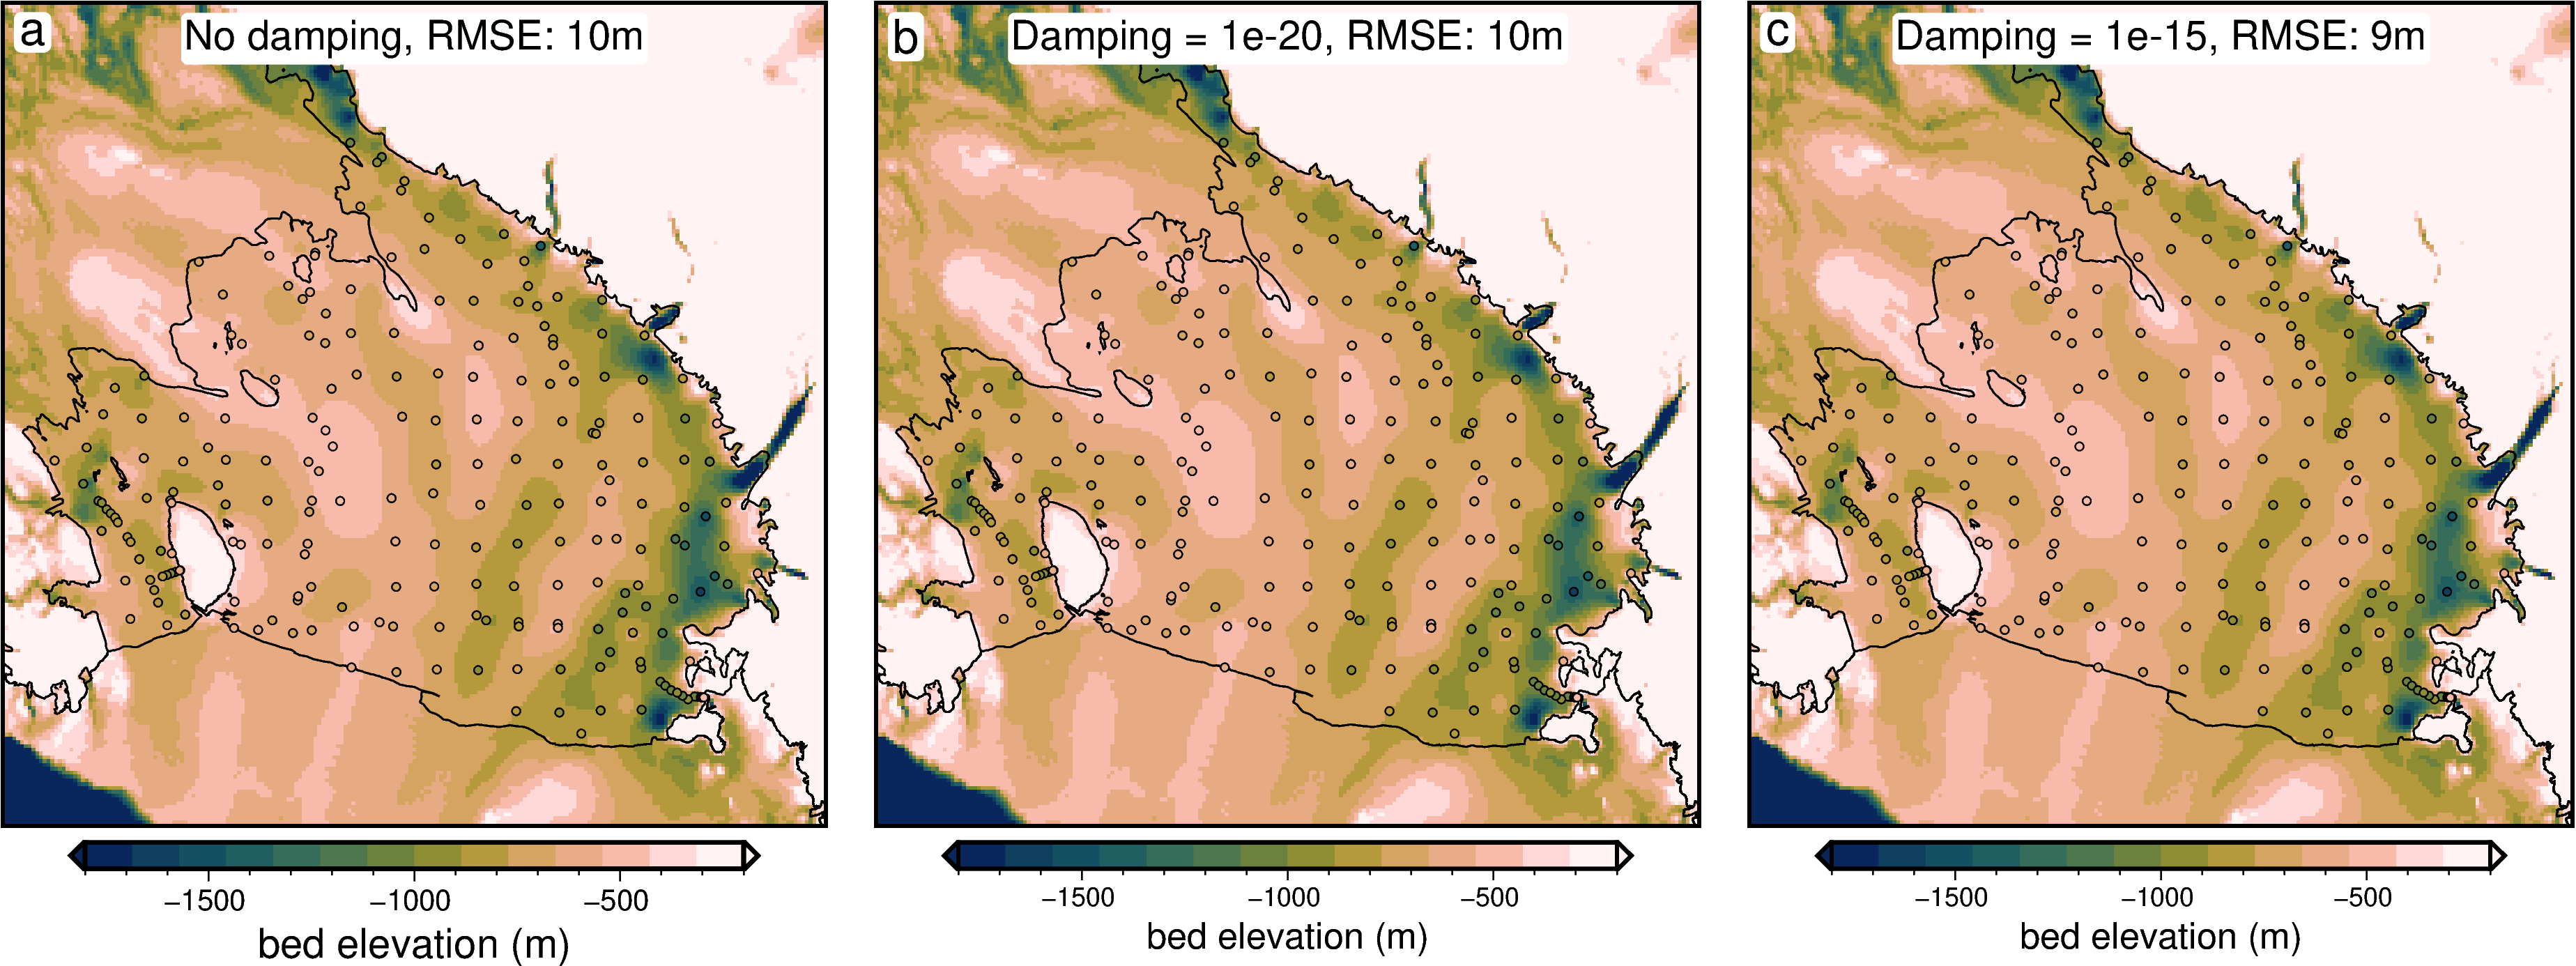

In [42]:
# set plot region
region = buffer_region

lims = [-1400, -200]
pygmt.makecpt(
    cmap="batlowW",
    series=lims + [100],
    # series="-1600/-200/100",
    output="../plotting/tmp.cpt",
)

for i, g in enumerate(verde_spline_grids):
    # get RMSE difference at constraints
    points = profile.sample_grids(
        constraints[constraints.inside],
        g,
        "sampled_bed",
        coord_names=["easting", "northing"],
    )
    points["dif"] = points.upward - points.sampled_bed
    rmse = utils.RMSE(points.dif)

    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 1
        yshift_amount = 1
    elif i == 3:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = -2.04
        yshift_amount = -0.95
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1.02
        yshift_amount = 1

    fig = maps.plot_grd(
        g,
        fig_height=10,
        region=region,
        coast=True,
        coast_version="measures-v2",
        cmap="../plotting/tmp.cpt",
        cpt_lims=lims,
        cbar_label="bed elevation (m)",
        # hist=True,
        # cbar_yoffset=1,
        # hist_bin_num=50,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )
    # plot constraints
    fig.plot(
        x=constraints[constraints.inside].easting,
        y=constraints[constraints.inside].northing,
        fill=constraints[constraints.inside].upward,
        style="c.10c",
        pen=".4p,black",
        cmap="../plotting/tmp.cpt",
    )
    # plot titles
    fig.text(
        position="TC",
        text=f"Damping = {string(dampings[i])}, RMSE: {int(rmse)}m",
        fill="white",
        font="14p,Helvetica,black",
        offset="j0/.2",
        clearance="+tO",
    )
    # plot subplot labels
    fig.text(
        position="TL",
        text=string.ascii_lowercase[i],
        fill="white",
        font="16p,Helvetica,black",
        offset="j.2/.2",
        clearance="+tO",
    )
fig.show()

In [44]:
gmt_surface_grids = []
tensions = [0, 0.2, 0.4, 0.6, 0.8, 1]

for t in tensions:
    g = inv_utils.recreate_bed(
        inside_points=constraints[constraints.inside],
        buffer_points=buffer_points,
        outside_grid=bed_outside,
        region=buffer_region,
        fullres_spacing=1e3,
        layer_spacing=layer_spacing,
        method="surface",
        tension=t,
        icebase=bedmachine_icebase_layer_spacing,
        surface=bedmachine_surface_layer_spacing,
        icebase_fullres=bedmachine_icebase_1k,
        surface_fullres=bedmachine_surface_1k,
    )
    g = g.rename(f"surface_{t}")

    gmt_surface_grids.append(g)

spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling


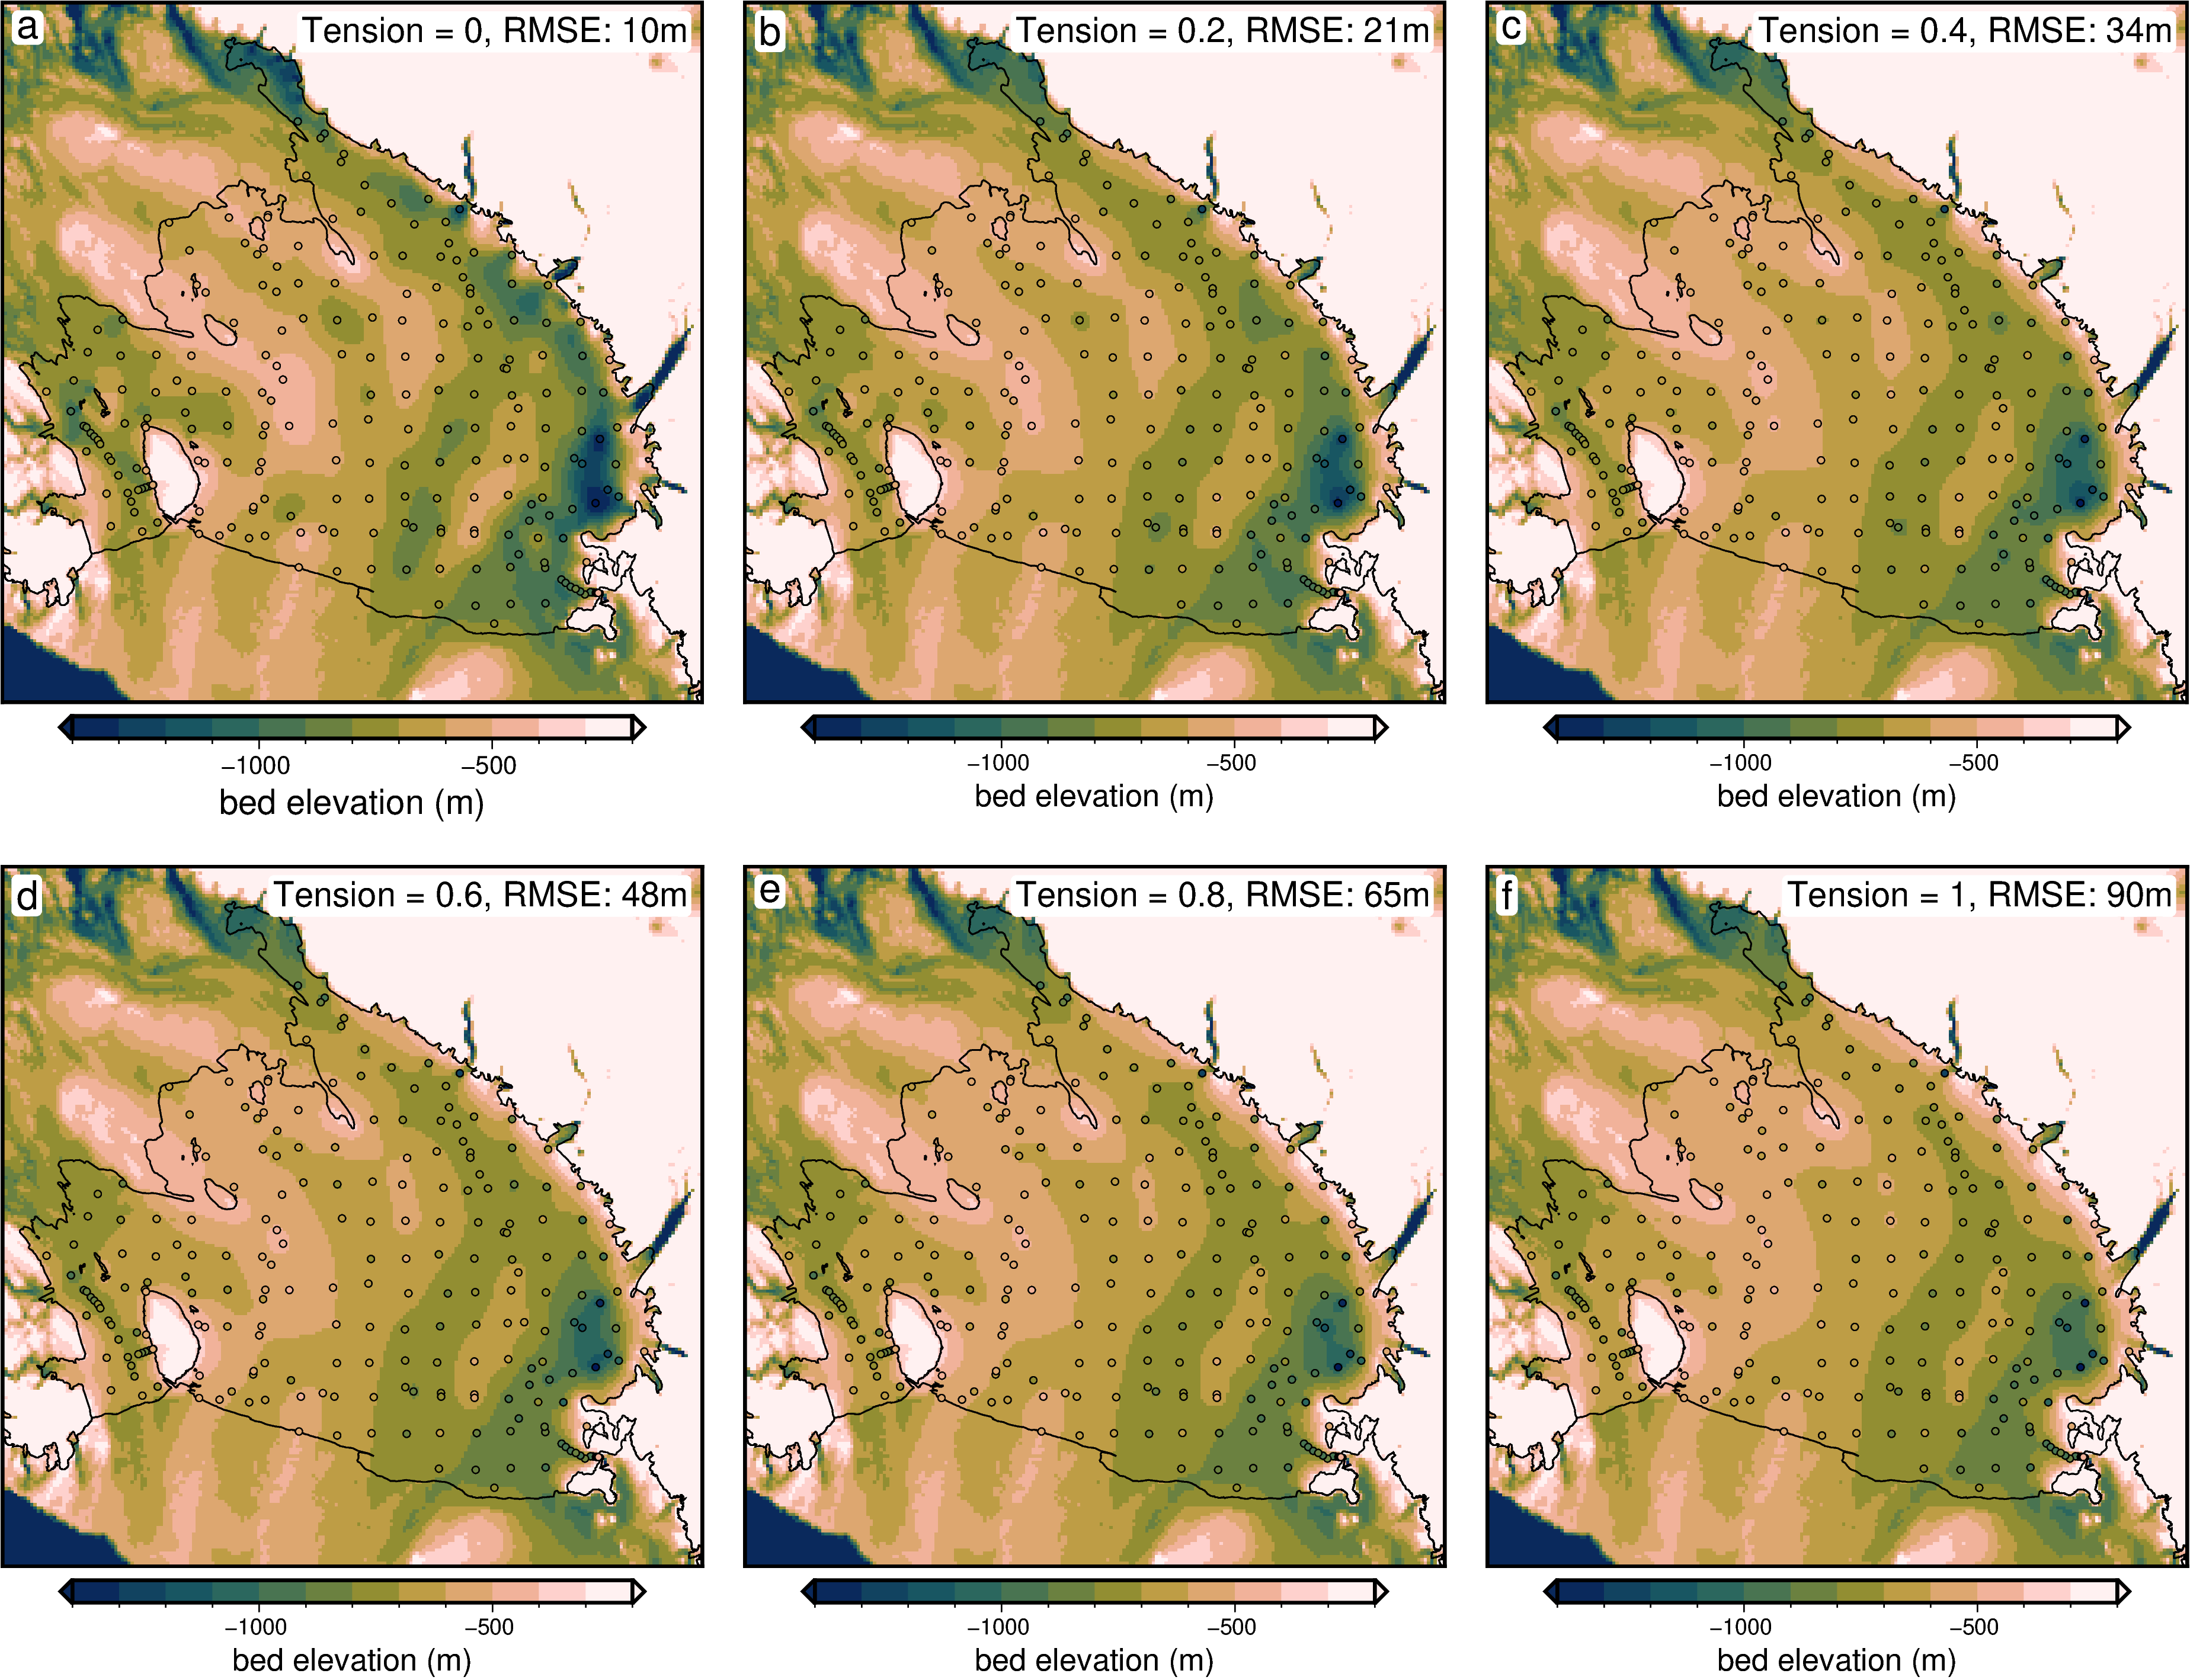

In [57]:
# set plot region
region = buffer_region

lims = [-1400, -200]
pygmt.makecpt(
    cmap="batlowW",
    series=lims + [100],
    # series="-1600/-200/100",
    output="../plotting/tmp.cpt",
)
rmses = []
for i, g in enumerate(gmt_surface_grids):
    # get RMSE difference at constraints
    points = profile.sample_grids(
        constraints[constraints.inside],
        g,
        "sampled_bed",
        coord_names=["easting", "northing"],
    )
    points["dif"] = points.upward - points.sampled_bed
    rmse = utils.RMSE(points.dif)
    rmses.append(rmse)
    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 1
        yshift_amount = 1
    elif i == 3:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = -2.04
        yshift_amount = -0.95
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1.02
        yshift_amount = 1

    fig = maps.plot_grd(
        g,
        fig_height=10,
        region=region,
        coast=True,
        coast_version="measures-v2",
        cmap="../plotting/tmp.cpt",
        cpt_lims=lims,
        cbar_label="bed elevation (m)",
        # hist=True,
        # cbar_yoffset=1,
        # hist_bin_num=50,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )
    # plot constraints
    fig.plot(
        x=constraints[constraints.inside].easting,
        y=constraints[constraints.inside].northing,
        fill=constraints[constraints.inside].upward,
        style="c.10c",
        pen=".4p,black",
        cmap="../plotting/tmp.cpt",
    )
    # plot titles
    fig.text(
        position="TR",
        justify="TR",
        text=f"Tension = {tensions[i]}, RMSE: {int(rmse)}m",
        fill="white",
        font="14p,Helvetica,black",
        offset="j.2/.2",
        clearance="+tO",
    )
    # plot subplot labels
    fig.text(
        position="TL",
        text=string.ascii_lowercase[i],
        fill="white",
        font="16p,Helvetica,black",
        offset="j.2/.2",
        clearance="+tO",
    )
fig.show()

In [58]:
combined = gmt_surface_grids

# save to zarr
combined = xr.merge(combined)
enc = {x: {"compressor": zarr.Blosc()} for x in combined}
combined.to_zarr(
    "../inversion_layers/RIS_starting_bed_models.zarr",
    encoding=enc,
    mode="w",
)

In [59]:
combined = xr.open_zarr("../inversion_layers/RIS_starting_bed_models.zarr")
combined_list = [combined[i] for i in combined]

In [78]:
stats = uncert.model_ensemble_stats(combined, weights=[1 / (x**2) for x in rmses])

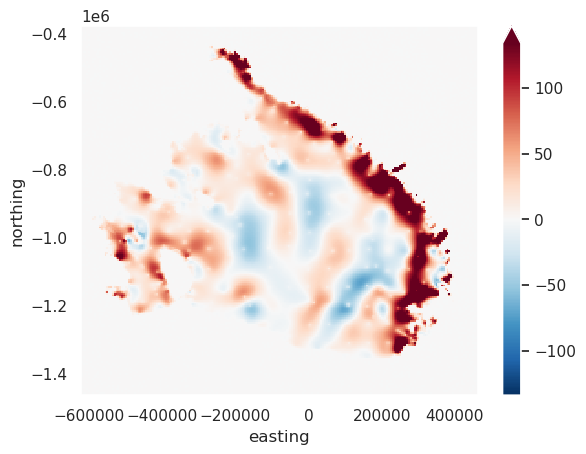

In [77]:
(stats.z_mean - stats_weights.weighted_mean).plot(robust=True)

In [79]:
# save to zarr
enc = {x: {"compressor": zarr.Blosc()} for x in stats}
stats.to_zarr(
    "../inversion_layers/RIS_starting_bed_stats.zarr",
    encoding=enc,
    mode="w",
)

In [69]:
stats = xr.open_zarr("../inversion_layers/RIS_starting_bed_stats.zarr")

# Plots

In [ ]:
constraints_fname = "../data/bed_constraints.csv.gz"

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
constraints

In [ ]:
constraints = profile.sample_grids(
    constraints,
    bed_from_constraints_verde_spline,
    "upward_verde_spline",
    coord_names=["easting", "northing"],
)
constraints = profile.sample_grids(
    constraints,
    bed_from_constraints_gmt_surface,
    "upward_gmt_surface",
    coord_names=["easting", "northing"],
)
constraints = profile.sample_grids(
    constraints,
    bedmap2_bed,
    "upward_bedmap2",
    coord_names=["easting", "northing"],
)
constraints = profile.sample_grids(
    constraints,
    bedmachine_bed,
    "upward_bedmachine",
    coord_names=["easting", "northing"],
)
constraints

In [ ]:
constraints["upward_diff_verde_spline"] = (
    constraints.upward - constraints.upward_verde_spline
)

constraints["upward_diff_gmt_surface"] = (
    constraints.upward - constraints.upward_gmt_surface
)

constraints["upward_diff_bedmap2"] = constraints.upward - constraints.upward_bedmap2

constraints["upward_diff_bedmachine"] = (
    constraints.upward - constraints.upward_bedmachine
)
constraints

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_bedmap2

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    bedmap2_bed,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. Bedmap2 grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    bedmap2_bed,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_bedmachine
grid = bedmachine_bed
name = "bedmachine bed"

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. {name} grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_gmt_surface
grid = bed_from_constraints_gmt_surface
name = "GMT surface"

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. {name} grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_verde_spline
grid = bed_from_constraints_verde_spline
name = "verde spline"

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. {name} grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

# Comparisons

In [ ]:
bed_from_constraints_verde_spline_clip = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    xr_grid=bed_from_constraints_verde_spline,
    masked=True,
    invert=False,
)

bed_from_constraints_gmt_surface_clip = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    xr_grid=bed_from_constraints_gmt_surface,
    masked=True,
    invert=False,
)

bedmachine_bed_clip = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    xr_grid=bedmachine_bed,
    masked=True,
    invert=False,
)

bedmap2_bed_clip = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    xr_grid=bedmap2_bed,
    masked=True,
    invert=False,
)

## compare spline and surface

In [ ]:
_ = utils.grd_compare(
    bed_from_constraints_verde_spline_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    grid1_name="with Verde Spline",
    grid2_name="with GMT Surface",
    diff_name="starting bed",
)

## compare with bedmachine

In [ ]:
_ = utils.grd_compare(
    bedmachine_bed_clip,
    bed_from_constraints_verde_spline_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmachine",
    grid2_name="Starting bed (Spline)",
)

In [ ]:
_ = utils.grd_compare(
    bedmachine_bed_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmachine",
    grid2_name="Starting bed (Surface)",
)

## compare with bedmap2

In [ ]:
_ = utils.grd_compare(
    bedmap2_bed_clip,
    bed_from_constraints_verde_spline_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmap2",
    grid2_name="Starting bed (Spline)",
)

In [ ]:
_ = utils.grd_compare(
    bedmap2_bed_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmap2",
    grid2_name="Starting bed (Surface)",
)

## Plot ocean draft

In [ ]:
starting_bed_ocean_draft = bedmachine_icebase - bed_from_constraints
fig = maps.plot_grd(
    starting_bed_ocean_draft,
    region=regions.ross_ice_shelf,
    cmap="rain",
    # reverse_cpt=True,
    grd2cpt=True,
    cpt_lims=[0, 100],
    hist=True,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.08c",
    fill="black",
)

bedmap2_ocean_draft = bedmap2_icebase - bedmap2_bed
fig = maps.plot_grd(
    bedmap2_ocean_draft,
    region=regions.ross_ice_shelf,
    cmap="rain",
    # reverse_cpt=True,
    grd2cpt=True,
    cpt_lims=[0, 100],
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.08c",
    fill="black",
)


bedmachine_ocean_draft = bedmachine_icebase - bedmachine_bed
fig = maps.plot_grd(
    bedmachine_ocean_draft,
    region=regions.ross_ice_shelf,
    cmap="rain",
    # reverse_cpt=True,
    grd2cpt=True,
    cpt_lims=[0, 100],
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.08c",
    fill="black",
)
fig.show()

In [ ]:
up_deriv = np.abs(
    inv_utils.filter_grid(bed_from_constraints.load(), filt_type="up_deriv")
)

pygmt.grd2cpt(
    grid=bed_from_constraints,
    cmap="rain",
    reverse=True,
    limit="-1500/0",
    nlevels=16,  # background=True,
    output="../plotting/RIS_bathy.cpt",
)
fig = maps.plot_grd(
    bed_from_constraints,
    fig_height=10,
    coast=True,
    # coast_version="measures-v2",
    region=regions.ross_ice_shelf,
    cmap="../plotting/RIS_bathy.cpt",  # "rain",
    # reverse_cpt=True,
    # grd2cpt=True,
    cpt_lims=[-1500, 0],
    cbar_label="Starting bed (m)",
    hist=True,
    cbar_yoffset=1.5,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
info = utils.set_proj(
    regions.ross_ice_shelf,
    fig_height=10,
)
maps.add_scalebar(fig, regions.ross_ice_shelf, info[1], position="n.2/-.05")

fig = maps.plot_grd(
    up_deriv,
    coast=True,
    # coast_version="measures-v2",
    region=regions.ross_ice_shelf,
    cmap="matter",
    grd2cpt=True,
    hist=True,
    cbar_yoffset=1.5,
    cbar_label="Upward derivative (absolute value)",
    robust=True,
    cpt_lims=[0, 0.1],
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
fig.show()

# Method 2: Grid point data, RIGGS inside RIS, bedmachine outside

In [ ]:
fig = maps.plot_grd(
    bedmachine_RIGGS_filled,
    cmap="rain",
    reverse_cpt=True,
    grd2cpt=True,
    hist=True,
    cbar_yoffset=4,
)
fig.show()

### grid with verde.Spline()

In [ ]:
import harmonica as hm

eqs = hm.EquivalentSourcesGB()
eqs.estimate_required_memory(
    (inner_constraints.x, inner_constraints.y, inner_constraints.y)
)

In [ ]:
import psutil

mem = psutil.virtual_memory()
mem

In [ ]:
mem[4]

### block reduce the data

In [ ]:
reduced_constraints = utils.block_reduce(
    inner_constraints,
    np.median,
    spacing=5e3,
    input_coord_names=["x", "y"],
)
reduced_constraints

In [ ]:
spline = vd.SplineCV(
    dampings=np.logspace(-6, 3, num=10, dtype=np.float32),
    # delayed=False
)

In [ ]:
# spline = vd.Spline(
#     damping=.1,
#     # delayed=False,
# )

In [ ]:
spline.fit(
    (reduced_constraints.x, reduced_constraints.y),
    reduced_constraints.z_ellipsoidal,
)

In [ ]:
bedmachine_RIGGS_filled_vd = spline.grid(region=region, spacing=spacing).scalars

In [ ]:
fig = maps.plot_grd(
    bedmachine_RIGGS_filled_vd,
    cmap="rain",
    reverse_cpt=True,
    grd2cpt=True,
    hist=True,
    cbar_yoffset=4,
    points=reduced_constraints,
    points_style="c0.05c",
)
fig.show()

In [ ]:
difference = bedmachine_RIGGS_filled - bedmachine_RIGGS_filled_vd

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    # grd2cpt=True,
    cbar_label="PyGMT Surface vs. Verde Spline",
    cpt_lims=[-200, 200],
    region=regions.ross_ice_shelf,
    hist=True,
    cbar_yoffset=3,
    hist_ymax=20e3,
)

fig.show()

### Compare to the Bedmachine

In [ ]:
difference = bedmachine_bed - bedmachine_RIGGS_filled

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    # grd2cpt=True,
    cbar_label="Bedmachine vs RIGGS-filled (m)",
    cpt_lims=[-200, 200],
    region=regions.ross_ice_shelf,
    hist=True,
    cbar_yoffset=3,
    hist_ymax=20e3,
)

fig.show()

Compare to Bedmap2

In [ ]:
difference = bedmap2_bed - bedmachine_RIGGS_filled

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    # grd2cpt=True,
    cbar_label="Bedmap2 vs RIGGS-filled (m)",
    cpt_lims=[-200, 200],
    region=regions.ross_ice_shelf,
    hist=True,
    cbar_yoffset=3,
)

fig.show()

## Save to a .zarr file

In [ ]:
bedmachine_RIGGS_filled = bedmachine_RIGGS_filled.to_dataset(name="bed")

bedmachine_RIGGS_filled.to_zarr(
    "../inversion_layers/bedmachine_RIGGS_filled.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)

### Load .zarr file

In [ ]:
bedmachine_RIGGS_filled = xr.open_zarr(
    "../inversion_layers/bedmachine_RIGGS_filled.zarr"
)["bed"]
maps.plot_grd(
    bedmachine_RIGGS_filled,
    region=regions.ross_ice_shelf,
    cmap="rain",
    reverse_cpt=True,
    grd2cpt=True,
)

## Replace grid cells at constraints and interpolate

### Mask grid within 2km of constraint points

In [ ]:
bed_constraints = pd.read_csv(
    "../ross_ice_shelf_bed_data.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
bed_constraints.describe()

In [ ]:
spacing, region, *_ = utils.get_grid_info(bedmap_bedmachine_merge)

coords = vd.grid_coordinates(region, spacing=spacing)
grid = vd.make_xarray_grid(coords, data=np.ones_like(coords[0]), data_names="z")

mask = vd.distance_mask(
    (bed_constraints.x, bed_constraints.y),
    maxdist=2e3,
    grid=grid,
)
mask = mask.rename({"northing": "y", "easting": "x"})
mask.z.plot()

### Grid the RIGGS points

In [ ]:
# Tension factor; 0-1,
# 0 gives minimum curvature,
# 1 gives harmonic surface (max min only at constraints)
# 0.35 recommended for topography
RIGGS = pygmt.surface(
    data=bed_constraints[["x", "y", "z_ellipsoidal"]],
    region=region,
    spacing=spacing,
    T=0.35,  # tension factor
)
RIGGS.plot()

### Merge masked grid with RIGGS grid

In [ ]:
bedmap_bedmachine_RIGGS = RIGGS.where(mask.z.notnull(), bedmap_bedmachine_merge)
bedmap_bedmachine_RIGGS.plot()

### Compare to the Bedmap2-Bedmachine

In [ ]:
grids = utils.grd_compare(
    bedmap_bedmachine_merge,
    bedmap_bedmachine_RIGGS,
    region=regions.ross_ice_shelf,
    shp_mask="../plotting/RIS_outline.shp",
    plot=True,
    # diff_maxabs=100,
)

# Other

In [ ]:
# mask bedmap/bedmachine merged grid at RIGGS points
# !gmt grdmask bedmap_bed_RIS.csv -S1c -N1/NaN/NaN -I1000 -R-1560000/1400000/-2400000/560000 -Gplotting/RIGGS_mask.nc
# !gmt grdmath -Df bedmap_bedmachine_merge.nc plotting/RIGGS_mask.nc MUL = bedmap_bedmachine_RIGGS_clip.nc
# RIGGS_holes = pygmt.grd2xyz("bedmap_bedmachine_RIGGS_clip.nc")
# RIGGS_holes.dropna(inplace=True)

# merge bedmap/bedmachine data with RIGGS points
# bedmap_RIS_df_merge = bedmap_RIS_df[['x', 'y', 'BedElevation']].copy().rename(columns={'BedElevation':'z'})
# bedmap_RIS_df_merge.dropna(inplace=True)
# bedmap_bedmachine_RIGGS = RIGGS_holes.merge(bedmap_RIS_df_merge, how='outer')
# bedmap_bedmachine_RIGGS_grd = pygmt.xyz2grd(bedmap_bedmachine_RIGGS, region='-1560000/1400000/-2400000/560000', spacing=1000)
# pygmt.grdfill(grid=bedmap_bedmachine_RIGGS_grd, outgrid = 'bedmap_bedmachine_RIGGS_grd_fill.nc', mode='n')

# merge RIGGS points with points outside RIS
# bedmachine_clip = pygmt.grd2xyz('bedmachine_clip.nc')
# bedmachine_clip.dropna(inplace=True)

# bedmachine_RIGGS = bedmachine_clip.merge(bedmap_RIS_df_merge, how='outer')
# bedmachine_RIGGS.to_csv('bedmachine_RIGGS.csv', index=False)
# # bedmachine_RIGGS = pd.read_csv('bedmachine_RIGGS.csv', index_col=False,)
# pygmt.xyz2grd(bedmachine_RIGGS, region='-1560000/1400000/-2400000/560000', outgrid='bathy_control_points.nc', spacing=1000)

# Bedmap2 - Bedmachine difference

In [ ]:
difference = bedmachine_bed - bedmap2_bed

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    grd2cpt=True,
    cpt_lims=[-200, 200],
    cbar_label="Bedmap2 vs Bedmachine bed (m)",
    hist=True,
    cbar_yoffset=4,
)

fig.show()

# Clip Bedmap2 data outside of RIS

In [ ]:
# bedmap2_bed_masked = utils.mask_from_shp(
#     "../plotting/RIS_outline.shp",
#     xr_grid=bedmap2_bed,
#     masked=True,
#     invert=False,
# )

# bedmap2_bed_masked.plot()

# Clip BedMachine data inside RIS

In [ ]:
# bedmachine_bed_masked = utils.mask_from_shp(
#     "../plotting/RIS_outline.shp",
#     xr_grid=bedmachine_bed,
#     masked=True,
#     invert=True,
# )

# bedmachine_bed_masked.plot()

# Merge Bedmap2 (RIS) with BedMachine (elsewhere)

In [ ]:
# bedmap_bedmachine_merge = bedmap2_bed_masked.where(
#     bedmap2_bed_masked.notnull(), bedmachine_bed_masked
# )
# bedmap_bedmachine_merge.plot()

## Compare full bedmachine grid with merged grid

In [ ]:
# difference = bedmachine_bed - bedmap_bedmachine_merge

# fig = maps.plot_grd(
#     difference,
#     region=regions.ross_ice_shelf,
#     cmap="balance+h0",
#     cpt_lims=[-200, 200],
#     cbar_label="Bedmachine vs bedmap2/bedmachine merged (m)",
#     hist=True,
#     cbar_yoffset=4,
#     hist_ymax=30e3,
# )

# fig.show()

## Compare full bedmap2 grid with merged grid

In [ ]:
# difference = bedmap2_bed - bedmap_bedmachine_merge

# fig = maps.plot_grd(
#     difference,
#     region=regions.ross_ice_shelf,
#     cmap="balance+h0",
#     cpt_lims=[-200, 200],
#     cbar_label="Bedmap2 vs bedmap2/bedmachine merged (m)",
#     hist=True,
#     cbar_yoffset=4,
# )

# fig.show()

## Save to a .zarr file

In [ ]:
bedmap_bedmachine_merge = bedmap_bedmachine_merge.to_dataset(name="bed")

bedmap_bedmachine_merge.to_zarr(
    "../inversion_layers/bedmap_bedmachine_merge.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)

## Load .zarr file

In [ ]:
bedmap_bedmachine_merge = xr.open_zarr(
    "../inversion_layers/bedmap_bedmachine_merge.zarr"
)["bed"]
bedmap_bedmachine_merge